# PQ

PQ（Product Quantization，乘积量化）是一种高效的向量压缩与近似距离计算方法

PQ 的核心思想是：

将高维向量拆分为多个子向量，在子空间内进行独立量化(使用中心节点向量代替实际向量)，再通过查表法快速计算近似距离

## PQ的核心优势

- 高压缩率：将浮点向量压缩为整数索引，存储占用大幅下降
- 高效距离计算：通过查表法快速估算距离，降低计算量
- 可组合性强：可与 IVF、HNSW 等索引结构结合，实现高效大规模检索；
- 近似精度可调：通过调整子向量数m 和 聚类中心数k 平衡精度与存储。

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.cluster.vq import kmeans2, vq
from scipy.spatial.distance import cdist

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

np.random.seed(42)

In [ ]:
class ProductQuantization:
    '''
    乘积量化算法实现
    '''
    def __init__(self, M=8, K=256) -> None:
        '''
        M: 子空间数量（将原始向量分割成多少段）
        K: 每个子空间的聚类中心数量（必须是2的幂次）
        '''
        self.M = M
        self.K = K
        self.codebooks = None # 码本: 存储每个子空间的聚类中心 shape(M, K, sub_dim) M个子空间，每个子空间K个质心，每个质心sub_dim维度
        self.sub_dim = None   # 每个子空间的维度
        self.is_trained = False

    def train(self, vectors, max_iters=100):
        '''
        训练PQ的码本
        vectors: 训练数据，shape(n_vectors, dim)
        max_iter: K-means最大迭代次数
        '''
        n_vectors, dim = vectors.shape

        if dim % self.M != 0:
            raise ValueError(f'vector dimension:{dim} can not be divisible by M:{self.M}')

        self.sub_dim = dim // self.M
        self.codebooks = np.zeros((self.M, self.K, self.sub_dim), dtype=np.float32)

        print(f'Start training PQ codebooks: the {dim}-dimension vector is partitioned into {self.M} subspaces, each subspace has {self.sub_dim}-dimensional.')
        print(f"Each subspace uses K={self.K} cluster centers")

        for m in range(self.M):
            print(f'Training subspace {m+1}/{self.M}...')

            # 提取当前子空间数据
            sub_vectors = vectors[:, m*self.sub_dim:(m+1)*self.sub_dim]
            
            # 使用K-means聚类
            # kmeans2返回聚类中心和每个点所属的簇标签
            centroids, labels = kmeans2(sub_vectors, self.K, iter=max_iters, minit='points') # minit='points' 表示从数据点中随机选择 K 个点作为初始质心
            self.codebooks[m] = centroids.astype(np.float32)
            
        self.is_trained = True
        print('PQ codebook training completed!')    
        return self.codebooks

    def encode(self, vectors):
        '''
        将向量编码为PQ码

        参数:
        - vectors: 待编码的向量，shape(n_vectors, dim)
        
        返回:
        - codes: PQ编码，shape(n_vectors, M) 每个元素都是[0,K-1]的整数
        '''
        if not self.is_trained:
            raise ValueError('Please Train PQ Codebook')

        n_vectors = vectors.shape[0]
        codes = np.zeros((n_vectors, self.M), dtype=np.uint8)

        for m in range(self.M):
            # 提取当前子空间的向量
            sub_vectors = vectors[:, m*self.sub_dim: (m+1)*self.sub_dim] # shape(n_vectors, sub_dim)

            # 为每个子向量找到最近的聚类中心
            # labels：每个子向量对应的最近聚类中心索引（0 到 K-1 的整数），shape 为 (n_vectors,1)
            labels, _ = vq(sub_vectors, self.codebooks[m]) # self.codebooks[m] 第m个子空间的K个质心，shape(K, sub_dim)
            codes[:, m] = labels

        return codes

    def decode(self, codes):
        '''
        将PQ码解码为近似向量
        参数:
        - codes: PQ编码 shape(n_vectors, M)
        返回:
        - approx_vectors: 近似向量，shape(n_vectors, dim) dim=sub_dim*M
        '''
        if not self.is_trained:
            raise ValueError('Please Train PQ Codebook')

        n_vectors = codes.shape[0]
        dim = self.M * self.sub_dim
        approx_vectors = np.zeros((n_vectors, dim), dtype=np.float32)

        for m in range(self.M):
            # 使用聚类中心向量的值代替编码
            approx_vectors[:, m*self.sub_dim:(m+1)*self.sub_dim] = \
                self.codebooks[m][codes[:, m]]

        return approx_vectors

    def build_distance_table(self, query):
        '''
        构建查询向量的距离表(ADC: Asymmetric Distance Computation) 不对称距离计算

        参数:
        - query: 查询向量 shape(dim,)
        
        返回:
        - dist_table: 距离表 shape(M, K)
        '''
        if not self.is_trained:
            raise ValueError('Please Train PQ Codebook') 

        dist_table = np.zeros((self.M, self.K), dtype=np.float32)

        for m in range(self.M):
            # 提取查询向量的子向量
            query_sub = query[m*self.sub_dim: (m+1)*self.sub_dim]

            # 计算 查询子向量 到 当前子空间 所有 聚类中心 的距离
            dist_table[m] = cdist([query_sub], self.codebooks[m], 'sqeuclidean')[0] # sqeuclidean = Squared Euclidean Distance（平方欧氏距离）不开平方的欧氏距离

        return dist_table

    def search(self, query, codes, top_k=5):
        '''
        使用PQ进行ANN搜索

        参数:
        - query: 查询向量 shape(dim, )
        - codes: 数据库向量的PQ编码，shape(n_vectors, M), 被查询的向量集
        - top_k: 返回最相似的top_k个结果
        
        返回:
        - indices: ANN的向量索引
        - distances: 对应的向量距离
        '''
        if not self.is_trained:
            raise ValueError('Please Train PQ Codebook')

        dist_table = self.build_distance_table(query) # (M, K) query每个子向量到每个子空间的所有聚类中心的距离

        n_vectors = codes.shape[0]
        distances = np.zeros(n_vectors, dtype=np.float32)

        # 计算每个数据库向量与查询向量的近似距离
        for i in range(n_vectors):
            for m in range(self.M):
                # 累加每个子空间的距离
                # codes[i, m]：第 i 个数据库向量在第 m 个子空间中的编码
                # dist_table[m, k]：查询向量的第 m 个子向量到第 m 个子空间中第 k 个聚类中心的距离
                # dist_table[m, codes[i, m]]：查询向量的第 m 个子向量到第 i 个数据库向量在第 m 个子空间所属聚类中心的距离
                distances[i] += dist_table[m, codes[i, m]]

        # 返回距离最小的top_k个结果
        indices = np.argsort(distances)[:top_k]
        return indices, distances[indices]

    def brute_force_search(self, query, vectors, top_k=5):
        distances = cdist([query], vectors, 'sqeuclidean')[0]
        indices = np.argsort(distances)[:top_k]
        return indices, distances[indices]

In [8]:
def generate_sample_data(n_samples=1000, dim=128):
    ''' 生成示例数据 '''
    np.random.seed(42)

    centers = [
        np.random.normal(2, 1, dim),
        np.random.normal(-1, 0.5, dim),
        np.random.normal(0, 1.5, dim),
        np.random.normal(3, 0.8, dim)
    ]

    data = []
    for i in range(n_samples):
        center_idx = i % len(centers)
        point = centers[center_idx] + np.random.normal(0, 0.3, dim)
        data.append(point)

    return np.array(data, dtype=np.float32)


In [10]:
data = generate_sample_data()
data.shape

(1000, 128)

In [19]:
def run_pq():
    '''
    完整演示PQ算法
    '''
    print("=" * 60)
    print("PQ算法演示")
    print("=" * 60)

    # 1. 生成数据
    dim = 128
    n_train = 5000 # 训练的vectors数量 
    n_database = 10000 # 数据库里的 vectors数量 
    
    print("生成训练数据...")
    train_vectors = generate_sample_data(n_train, dim)
    database_vectors = generate_sample_data(n_database, dim)

    print(f"训练数据: {train_vectors.shape}")
    print(f"数据库数据: {database_vectors.shape}")

    # 2. 创建并训练PQ
    pq = ProductQuantization(M=8, K=256)

    start_time = time.time()
    pq.train(train_vectors)
    train_time = time.time() - start_time
    print(f"PQ训练耗时: {train_time:.4f}秒")

    # 3. 编码数据库向量
    start_time = time.time()
    database_codes = pq.encode(database_vectors)
    encode_time = time.time() - start_time

    compression_ratio = (database_vectors.nbytes) / (database_codes.nbytes + pq.codebooks.nbytes)
    print(f"编码耗时: {encode_time:.4f}秒")
    print(f"压缩比: {compression_ratio:.2f}x")
    print(f"原始大小: {database_vectors.nbytes / 1024:.2f} KB")
    print(f"压缩后: {(database_codes.nbytes + pq.codebooks.nbytes) / 1024:.2f} KB")
    
    # 4. 搜索测试
    query = generate_sample_data(1, dim)[0]

    # PQ搜索
    start_time = time.time()
    pq_indices, pq_distances = pq.search(query, database_codes, top_k=5)
    pq_time = time.time() - start_time

    # 暴力搜索
    start_time = time.time()
    bf_indices, bf_distances = pq.brute_force_search(query, database_vectors, top_k=5)
    bf_time = time.time() - start_time

    # 显示结果对比
    print(f"\n搜索结果对比:")
    print(f"PQ搜索    - 找到{len(pq_indices)}个最近邻, 耗时: {pq_time:.6f}秒")
    print(f"暴力搜索 - 找到{len(bf_indices)}个最近邻, 耗时: {bf_time:.6f}秒")
    print(f"速度提升: {bf_time/pq_time:.2f}倍")
    
    print(f"\nPQ结果索引: {pq_indices}")
    print(f"PQ结果距离: {pq_distances}")
    print(f"暴力搜索结果索引: {bf_indices}")
    print(f"暴力搜索结果距离: {bf_distances}")

    # 检查召回率
    intersection = set(pq_indices) & set(bf_indices)
    recall = len(intersection) / len(bf_indices)
    print(f"Top-{len(bf_indices)}召回率: {recall:.2%} ({len(intersection)}/{len(bf_indices)})")
    
    return pq, database_vectors, database_codes, query, pq_indices, bf_indices


In [20]:
pq, vectors, codes, query, pq_results, bf_results = run_pq()

PQ算法演示
生成训练数据...
训练数据: (5000, 128)
数据库数据: (10000, 128)
Start training PQ codebooks: the 128-dimension vector is partitioned into 8 subspaces, each subspace has 16-dimensional.
Each subspace uses K=256 cluster centers
Training subspace 1/8...
Training subspace 2/8...
Training subspace 3/8...
Training subspace 4/8...
Training subspace 5/8...
Training subspace 6/8...
Training subspace 7/8...
Training subspace 8/8...
PQ codebook training completed!
PQ训练耗时: 10.5020秒
编码耗时: 0.1583秒
压缩比: 24.26x
原始大小: 5000.00 KB
压缩后: 206.12 KB

搜索结果对比:
PQ搜索    - 找到5个最近邻, 耗时: 0.103136秒
暴力搜索 - 找到5个最近邻, 耗时: 0.005997秒
速度提升: 0.06倍

PQ结果索引: [   0 1000 4472  512 4080]
PQ结果距离: [ 6.1899347 11.832801  12.133605  12.273722  12.286916 ]
暴力搜索结果索引: [   0 5260 9000 2456 5820]
暴力搜索结果距离: [ 0.         15.6129819  16.08607458 16.3027682  16.46445402]
Top-5召回率: 20.00% (1/5)


In [23]:
def visualize_pq_effect(pq, vectors, codes, query, pq_results, bf_results):
    """PQ效果可视化函数"""
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    
    # 为码本数据创建独立的PCA模型
    pca_original = PCA(n_components=2)
    
    # 1. 对原始数据进行PCA降维用于可视化
    vectors_2d = pca_original.fit_transform(vectors)
    query_2d = pca_original.transform([query])[0]
    
    plt.figure(figsize=(15, 5))
    
    # 子图1: 显示原始数据分布和搜索结果
    plt.subplot(1, 3, 1)
    plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], alpha=0.3, s=10, label='数据库向量')
    plt.scatter(vectors_2d[bf_results, 0], vectors_2d[bf_results, 1], 
               c='green', s=100, marker='s', label='真实最近邻')
    plt.scatter(vectors_2d[pq_results, 0], vectors_2d[pq_results, 1], 
               c='red', s=80, marker='o', label='PQ结果')
    plt.scatter(query_2d[0], query_2d[1], c='yellow', marker='*', 
               s=300, edgecolors='black', linewidth=2, label='查询点')
    plt.title('PQ搜索结果对比')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 子图2: 显示压缩误差（修复后的代码）
    plt.subplot(1, 3, 2)
    
    # 随机选择一些向量显示原始vs重建
    sample_indices = np.random.choice(len(vectors), min(10, len(vectors)), replace=False)
    original_samples = vectors[sample_indices]
    approx_samples = pq.decode(codes[sample_indices])
    
    # 计算重建误差
    errors = np.linalg.norm(original_samples - approx_samples, axis=1)
    
    plt.bar(range(len(errors)), errors, alpha=0.7)
    plt.title('PQ重建误差示例')
    plt.xlabel('样本索引')
    plt.ylabel('欧氏距离误差')
    plt.grid(True, alpha=0.3)
    
    # 子图3: 显示码本分布（修复关键错误）
    plt.subplot(1, 3, 3)
    if pq.codebooks is not None:
        # 将第一个子空间的所有聚类中心展平为2D数据
        sub_vectors = pq.codebooks[0].reshape(-1, pq.codebooks[0].shape[-1])
        
        # 检查数据有效性
        if len(sub_vectors) > 1 and sub_vectors.shape[1] > 0:
            pca_codebook = PCA(n_components=min(2, sub_vectors.shape[1]))
            centroids_2d = pca_codebook.fit_transform(sub_vectors)
            
            plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                       c=range(len(centroids_2d)), cmap='viridis', s=50)
            plt.colorbar(label='聚类中心索引')
            plt.title('第一个子空间的聚类中心分布')
        else:
            plt.text(0.5, 0.5, '码本数据不足或维度为0\n无法进行PCA可视化', 
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('码本可视化不可用')
        
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-1606663662.py:66: UserWarning: Glyph 25628 (\N{CJK UNIFIED IDEOGRAPH-641C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1606663662.py:66: UserWarning: Glyph 32034 (\N{CJK UNIFIED IDEOGRAPH-7D22}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1606663662.py:66: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1606663662.py:66: UserWarning: Glyph 26524 (\N{CJK UNIFIED IDEOGRAPH-679C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1606663662.py:66: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1606663662.py:66: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-1606663662.py:66: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missi

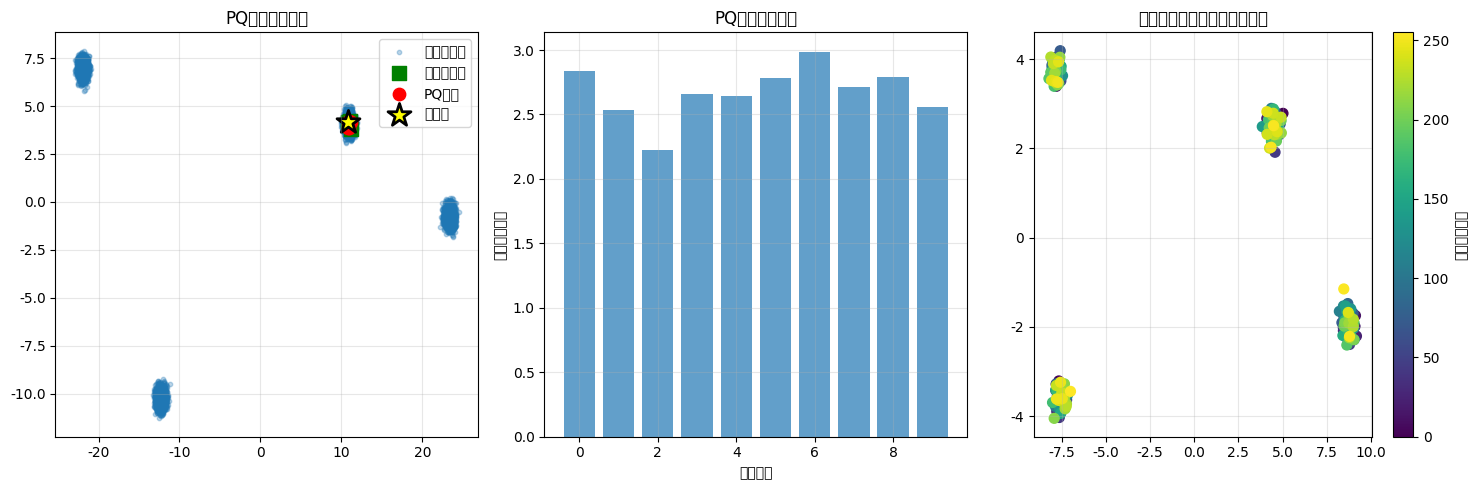

In [28]:

# 运行可视化
visualize_pq_effect(pq, vectors, codes, query, pq_results, bf_results)

# 结论

1. M（子空间数量）是影响PQ算法性能最关键的因素
   1. 召回率提升
   2. 时间成本增加
   3. 压缩比下降
2. 聚类中心数 (K) 的边际效益
   1. 在M同为8的情况下，将K增大4倍，召回率并未改善（均为20%），但训练和搜索时间有所增加。这暗示对于此数据集，在M=8时，单纯增加K可能已无法有效提升量化精度，模型可能受到了其他瓶颈的限制（例如数据分布或M值本身）。
3. 整体召回率偏低的原因探析
   1. 码本训练数据不足
   2. 参数组合仍未达到最优